In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import pandas as pd
from PyFunctions import Functions as func
from PyFunctions import var
from PyFunctions import Viz
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.applications import imagenet_utils
from keras.applications.vgg16 import VGG16
import cv2

Using plaidml.keras.backend backend.


# Mobilenet

In [2]:
def get_mobilenet(dim):
    model = Sequential()
    optimizer = Adam(lr = .0005)
    baseModel = MobileNetV2(weights="imagenet", include_top=False,
        input_tensor=Input(shape=dim))
    
    model.add(baseModel)
    model.add(AveragePooling2D(pool_size=(7, 7)))
    model.add(Flatten(name="flatten"))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation="softmax", name = 'Output'))

    
    for layer in baseModel.layers:
        layer.trainable = False
        
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

### V1: Edge and Augmentation

In [3]:
x_train, x_test, y_train, y_test = func.get_tts('mobilenet', version =1, edge = True, balance = True)


# cv2.imshow('test', x_train[25])
# cv2.waitKey(0)
# cv2.destroyAllWindows()

Train Value Counts
1    1368
0    1368
2    1233
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Test Value Counts
1    152
0    152
2    137
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
X Train Shape
(3969, 224, 224, 3)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
X Test Shape
(441, 224, 224, 3)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [4]:
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .00075)
model_checkpoint = ModelCheckpoint('ModelWeights/MV1_Edge_Augment.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 5, mode = 'min')
epochs = 2000
batch_size = 16
    
dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 3)
mobilenet = get_mobilenet(dim =dim)

    
augmentation =ImageDataGenerator(rotation_range = 20, width_shift_range = .2, height_shift_range = .2, 
                                                       horizontal_flip = True, shear_range = .15, 
                                 fill_mode = 'nearest', zoom_range = .15)
augmentation.fit(x_train)
mobilenet_history = mobilenet.fit_generator(augmentation.flow(x_train, y_train, batch_size = batch_size),
            epochs = epochs, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"
C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/2000


INFO:plaidml:Analyzing Ops: 1483 of 2044 operations complete


249/249 [==============================] - 86s 344ms/step - loss: 0.5005 - acc: 0.7533 - val_loss: 1.6469 - val_acc: 0.3968

Epoch 00001: val_loss improved from inf to 1.64688, saving model to ModelWeights/MV1_Edge_Augment.h5
Epoch 2/2000
249/249 [==============================] - 39s 159ms/step - loss: 0.4241 - acc: 0.7874 - val_loss: 0.5702 - val_acc: 0.7029

Epoch 00002: val_loss improved from 1.64688 to 0.57015, saving model to ModelWeights/MV1_Edge_Augment.h5
Epoch 3/2000
249/249 [==============================] - 39s 158ms/step - loss: 0.4112 - acc: 0.7899 - val_loss: 0.4592 - val_acc: 0.7891

Epoch 00003: val_loss improved from 0.57015 to 0.45921, saving model to ModelWeights/MV1_Edge_Augment.h5
Epoch 4/2000
249/249 [==============================] - 41s 165ms/step - loss: 0.3963 - acc: 0.8070 - val_loss: 0.4000 - val_acc: 0.7732

Epoch 00004: val_loss improved from 0.45921 to 0.39997, saving model to ModelWeights/MV1_Edge_Augment.h5
Epoch 5/2000
249/249 [=======================

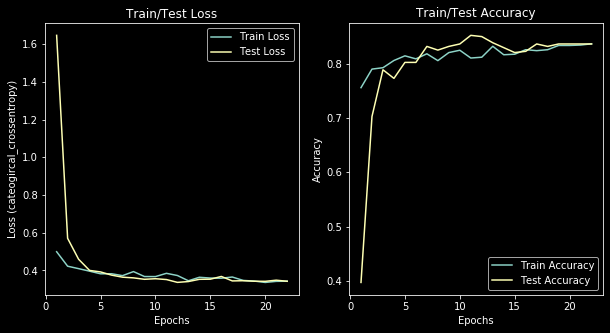

In [5]:
Viz.plot_loss_accuracy(mobilenet_history, 'dark_background', path = 'figures/MV1LossAcc_Edge_Augment.png')  

C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


F1 Scores Test
~~~~~~~~~~~~~~~~~~~~~~
No Weapon: 0.9966996699669968
HandGun: 0.7962382445141065
Rifle: 0.7461538461538463


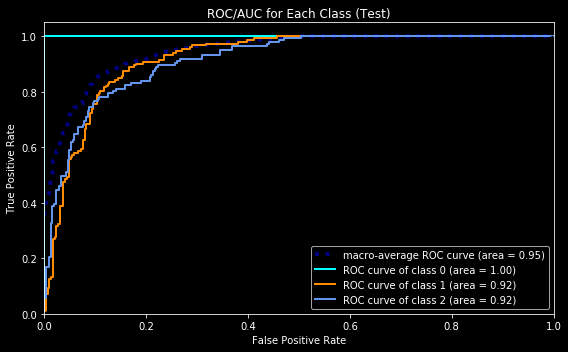

In [6]:
mobilenet = get_mobilenet(dim)
mobilenet.load_weights('ModelWeights/MV1_Edge_Augment.h5') #load the best weights before overfitting

Viz.plot_roc_auc(mobilenet, x_test, y_test, 'dark_background', 'figures/MV1ROC_Edge_Augment.png')

C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


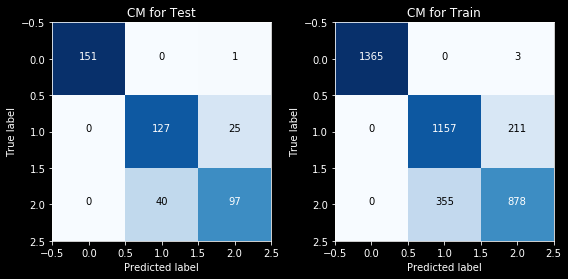

In [7]:
mobilenet = get_mobilenet(dim)
mobilenet.load_weights('ModelWeights/MV1_Edge_Augment.h5') #load the best weights before overfitting

y_test_prob = [np.argmax(i) for i in mobilenet.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

y_train_prob = [np.argmax(i) for i in mobilenet.predict(x_train)]
y_train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(y_train_labels, y_train_prob)

Viz.plot_model_cm(test_cnf, train_cnf, classes = ['No Weapon', 'Handgun', 'Rifle'], theme = 'dark_background', 
                  path = 'figures/MV1CM_Edge_Augment.png')

### V1: Edge & No Augment

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .00075)
model_checkpoint = ModelCheckpoint('ModelWeights/MV1_Edge_NoAugment.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 5, mode = 'min')
epochs = 2000
batch_size = 16
    
dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 3)
mobilenet = get_mobilenet(dim =dim)

    
mobilenet_history = mobilenet.fit(x_train, y_train, batch_size = batch_size,
            epochs = epochs, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)

C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Train on 3969 samples, validate on 441 samples
Epoch 1/2000


INFO:plaidml:Analyzing Ops: 1725 of 2044 operations complete


3969/3969 [==============================] - 75s 19ms/step - loss: 0.4595 - acc: 0.7821 - val_loss: 0.6791 - val_acc: 0.6259

Epoch 00001: val_loss improved from inf to 0.67912, saving model to ModelWeights/MV1_Edge_NoAugment.h5
Epoch 2/2000
3969/3969 [==============================] - 25s 6ms/step - loss: 0.3665 - acc: 0.8342 - val_loss: 0.4306 - val_acc: 0.7778

Epoch 00002: val_loss improved from 0.67912 to 0.43059, saving model to ModelWeights/MV1_Edge_NoAugment.h5
Epoch 3/2000
3969/3969 [==============================] - 25s 6ms/step - loss: 0.3482 - acc: 0.8362 - val_loss: 0.3726 - val_acc: 0.8231

Epoch 00003: val_loss improved from 0.43059 to 0.37263, saving model to ModelWeights/MV1_Edge_NoAugment.h5
Epoch 4/2000
3969/3969 [==============================] - 25s 6ms/step - loss: 0.3722 - acc: 0.8304 - val_loss: 0.3558 - val_acc: 0.8186

Epoch 00004: val_loss improved from 0.37263 to 0.35578, saving model to ModelWeights/MV1_Edge_NoAugment.h5
Epoch 5/2000
3969/3969 [============

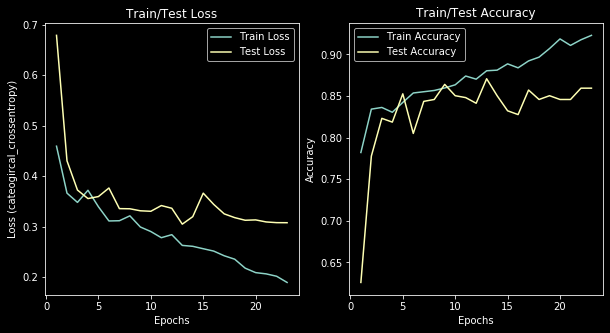

In [9]:
Viz.plot_loss_accuracy(mobilenet_history, 'dark_background', path = 'figures/MV1LossAcc_Edge_NoAugment.png')  

C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


F1 Scores Test
~~~~~~~~~~~~~~~~~~~~~~
No Weapon: 0.9966996699669968
HandGun: 0.8193548387096773
Rifle: 0.788104089219331


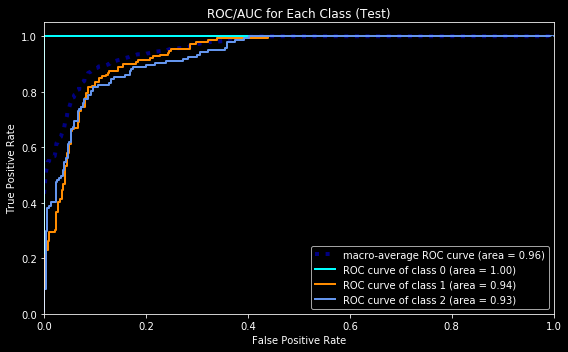

In [10]:
mobilenet = get_mobilenet(dim)
mobilenet.load_weights('ModelWeights/MV1_Edge_NoAugment.h5') #load the best weights before overfitting

Viz.plot_roc_auc(mobilenet, x_test, y_test, 'dark_background', 'figures/MV1ROC_Edge_NoAugment.png')

C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


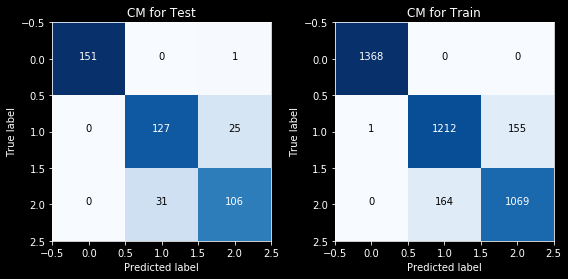

In [11]:
mobilenet = get_mobilenet(dim)
mobilenet.load_weights('ModelWeights/MV1_Edge_NoAugment.h5') #load the best weights before overfitting

y_test_prob = [np.argmax(i) for i in mobilenet.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

y_train_prob = [np.argmax(i) for i in mobilenet.predict(x_train)]
y_train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(y_train_labels, y_train_prob)

Viz.plot_model_cm(test_cnf, train_cnf, classes = ['No Weapon', 'Handgun', 'Rifle'], theme = 'dark_background', 
                  path = 'figures/MV1CM_Edge_NoAugment.png')

### V1 No Edge & Augment

In [12]:
x_train, x_test, y_train, y_test = func.get_tts('mobilenet', version =1, edge = False, balance = True)


# cv2.imshow('test', x_train[25])
# cv2.waitKey(0)
# cv2.destroyAllWindows()

Train Value Counts
1    1368
0    1368
2    1233
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Test Value Counts
1    152
0    152
2    137
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
X Train Shape
(3969, 224, 224, 3)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
X Test Shape
(441, 224, 224, 3)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [13]:
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .00075)
model_checkpoint = ModelCheckpoint('ModelWeights/MV1_NoEdge_Augment.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 5, mode = 'min')
epochs = 2000
batch_size = 16
    
dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 3)
mobilenet = get_mobilenet(dim =dim)

    
augmentation =ImageDataGenerator(rotation_range = 20, width_shift_range = .2, height_shift_range = .2, 
                                                       horizontal_flip = True, shear_range = .15, 
                                 fill_mode = 'nearest', zoom_range = .15)
augmentation.fit(x_train)
mobilenet_history = mobilenet.fit_generator(augmentation.flow(x_train, y_train, batch_size = batch_size),
            epochs = epochs, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)

C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/2000


INFO:plaidml:Analyzing Ops: 1302 of 2044 operations complete


249/249 [==============================] - 91s 366ms/step - loss: 0.5061 - acc: 0.7734 - val_loss: 0.9854 - val_acc: 0.6236

Epoch 00001: val_loss improved from inf to 0.98540, saving model to ModelWeights/MV1_NoEdge_Augment.h5
Epoch 2/2000
249/249 [==============================] - 41s 167ms/step - loss: 0.3956 - acc: 0.8306 - val_loss: 0.5763 - val_acc: 0.7415

Epoch 00002: val_loss improved from 0.98540 to 0.57627, saving model to ModelWeights/MV1_NoEdge_Augment.h5
Epoch 3/2000
249/249 [==============================] - 42s 170ms/step - loss: 0.3656 - acc: 0.8409 - val_loss: 0.5618 - val_acc: 0.7506

Epoch 00003: val_loss improved from 0.57627 to 0.56180, saving model to ModelWeights/MV1_NoEdge_Augment.h5
Epoch 4/2000
249/249 [==============================] - 42s 171ms/step - loss: 0.3623 - acc: 0.8514 - val_loss: 0.3171 - val_acc: 0.8639

Epoch 00004: val_loss improved from 0.56180 to 0.31711, saving model to ModelWeights/MV1_NoEdge_Augment.h5
Epoch 5/2000
249/249 [===============

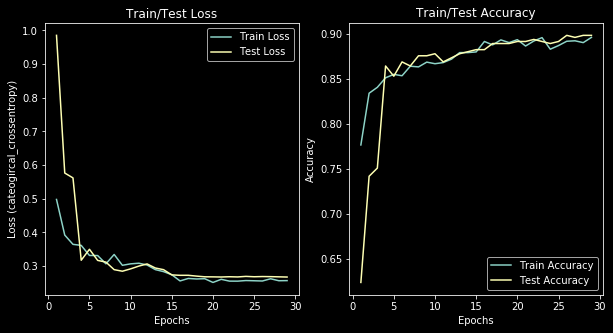

In [14]:
Viz.plot_loss_accuracy(mobilenet_history, 'dark_background', path = 'figures/MV1LossAcc_NoEdge_Augment.png')  

C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


F1 Scores Test
~~~~~~~~~~~~~~~~~~~~~~
No Weapon: 0.9966996699669968
HandGun: 0.8571428571428572
Rifle: 0.8339483394833948


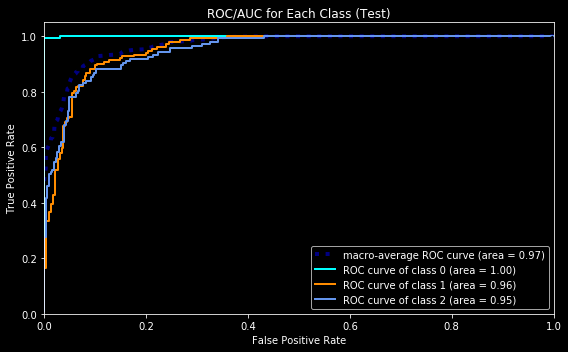

In [15]:
mobilenet = get_mobilenet(dim)
mobilenet.load_weights('ModelWeights/MV1_NoEdge_Augment.h5') #load the best weights before overfitting

Viz.plot_roc_auc(mobilenet, x_test, y_test, 'dark_background', 'figures/MV1ROC_NoEdge_Augment.png')

C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


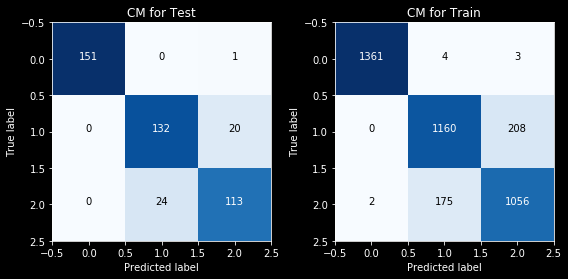

In [16]:
mobilenet = get_mobilenet(dim)
mobilenet.load_weights('ModelWeights/MV1_NoEdge_Augment.h5') #load the best weights before overfitting

y_test_prob = [np.argmax(i) for i in mobilenet.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

y_train_prob = [np.argmax(i) for i in mobilenet.predict(x_train)]
y_train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(y_train_labels, y_train_prob)

Viz.plot_model_cm(test_cnf, train_cnf, classes = ['No Weapon', 'Handgun', 'Rifle'], theme = 'dark_background', 
                  path = 'figures/MV1CM_NoEdge_Augment.png')

### V1: No Edge & No Augment

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .00075)
model_checkpoint = ModelCheckpoint('ModelWeights/MV1_NoEdge_NoAugment.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 5, mode = 'min')
epochs = 2000
batch_size = 16
    
dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 3)
mobilenet = get_mobilenet(dim =dim)

    
mobilenet_history = mobilenet.fit(x_train, y_train, batch_size = batch_size,
            epochs = epochs, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)

C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Train on 3969 samples, validate on 441 samples
Epoch 1/2000


INFO:plaidml:Analyzing Ops: 1544 of 2044 operations complete


3969/3969 [==============================] - 78s 20ms/step - loss: 0.4136 - acc: 0.8221 - val_loss: 0.6627 - val_acc: 0.7483

Epoch 00001: val_loss improved from inf to 0.66272, saving model to ModelWeights/MV1_NoEdge_NoAugment.h5
Epoch 2/2000
3969/3969 [==============================] - 27s 7ms/step - loss: 0.3248 - acc: 0.8660 - val_loss: 0.3958 - val_acc: 0.8322

Epoch 00002: val_loss improved from 0.66272 to 0.39576, saving model to ModelWeights/MV1_NoEdge_NoAugment.h5
Epoch 3/2000
3969/3969 [==============================] - 26s 7ms/step - loss: 0.2973 - acc: 0.8745 - val_loss: 0.2803 - val_acc: 0.8753

Epoch 00003: val_loss improved from 0.39576 to 0.28030, saving model to ModelWeights/MV1_NoEdge_NoAugment.h5
Epoch 4/2000
3969/3969 [==============================] - 26s 6ms/step - loss: 0.2955 - acc: 0.8743 - val_loss: 0.3249 - val_acc: 0.8617

Epoch 00004: val_loss did not improve from 0.28030
Epoch 5/2000
3969/3969 [==============================] - 26s 7ms/step - loss: 0.2555 

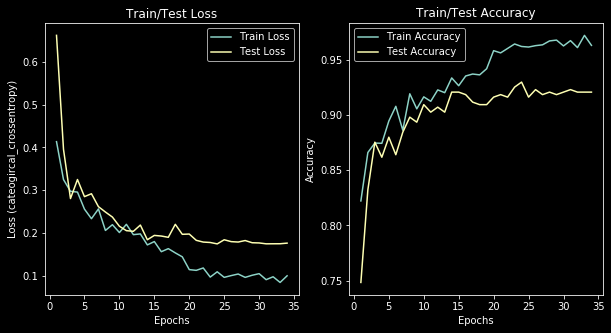

In [18]:
Viz.plot_loss_accuracy(mobilenet_history, 'dark_background', path = 'figures/MV1LossAcc_NoEdge_NoAugment.png')  

C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


F1 Scores Test
~~~~~~~~~~~~~~~~~~~~~~
No Weapon: 1.0
HandGun: 0.9015873015873016
Rifle: 0.8821292775665398


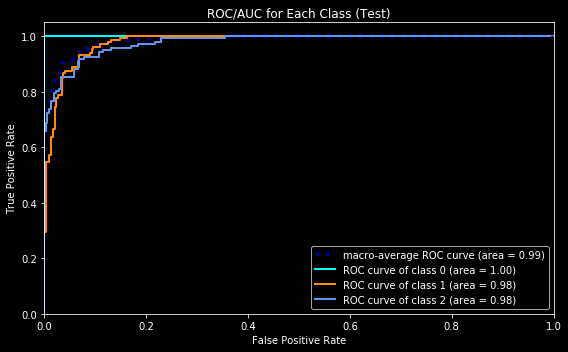

In [19]:
mobilenet = get_mobilenet(dim)
mobilenet.load_weights('ModelWeights/MV1_NoEdge_NoAugment.h5') #load the best weights before overfitting

Viz.plot_roc_auc(mobilenet, x_test, y_test, 'dark_background', 'figures/MV1ROC_NoEdge_NoAugment.png')

C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


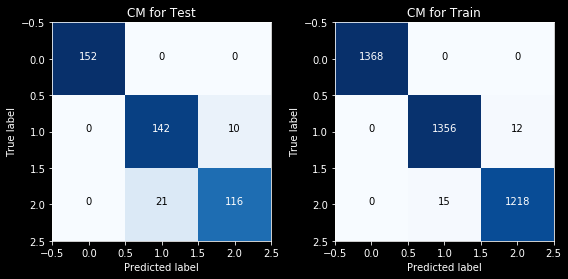

In [20]:
mobilenet = get_mobilenet(dim)
mobilenet.load_weights('ModelWeights/MV1_NoEdge_NoAugment.h5') #load the best weights before overfitting

y_test_prob = [np.argmax(i) for i in mobilenet.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

y_train_prob = [np.argmax(i) for i in mobilenet.predict(x_train)]
y_train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(y_train_labels, y_train_prob)

Viz.plot_model_cm(test_cnf, train_cnf, classes = ['No Weapon', 'Handgun', 'Rifle'], theme = 'dark_background', 
                  path = 'figures/MV1CM_NoEdge_NoAugment.png')

### V2: Edge & Augmentation

In [21]:
x_train, x_test, y_train, y_test = func.get_tts('mobilenet', version =2, edge = True, balance = True)

# cv2.imshow('test', x_train[25])
# cv2.waitKey(0)
# cv2.destroyAllWindows()

Train Value Counts
1    1368
0    1368
2    1233
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Test Value Counts
1    152
0    152
2    137
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
X Train Shape
(3969, 224, 224, 3)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
X Test Shape
(441, 224, 224, 3)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [22]:
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .00075)
model_checkpoint = ModelCheckpoint('ModelWeights/MV2_Edge_Augment.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 5, mode = 'min')
epochs = 2000
batch_size = 16
    
dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 3)
mobilenet = get_mobilenet(dim =dim)

    
augmentation =ImageDataGenerator(rotation_range = 20, width_shift_range = .2, height_shift_range = .2, 
                                                       horizontal_flip = True, shear_range = .15, 
                                 fill_mode = 'nearest', zoom_range = .15)
augmentation.fit(x_train)
mobilenet_history = mobilenet.fit_generator(augmentation.flow(x_train, y_train, batch_size = batch_size),
            epochs = epochs, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)

C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/2000


INFO:plaidml:Analyzing Ops: 1512 of 2044 operations complete


249/249 [==============================] - 98s 394ms/step - loss: 0.7434 - acc: 0.6647 - val_loss: 0.6737 - val_acc: 0.7234

Epoch 00001: val_loss improved from inf to 0.67367, saving model to ModelWeights/MV2_Edge_Augment.h5
Epoch 2/2000
249/249 [==============================] - 42s 170ms/step - loss: 0.6826 - acc: 0.7023 - val_loss: 0.7217 - val_acc: 0.6372

Epoch 00002: val_loss did not improve from 0.67367
Epoch 3/2000
249/249 [==============================] - 42s 168ms/step - loss: 0.6540 - acc: 0.7131 - val_loss: 0.6693 - val_acc: 0.7347

Epoch 00003: val_loss improved from 0.67367 to 0.66926, saving model to ModelWeights/MV2_Edge_Augment.h5
Epoch 4/2000
249/249 [==============================] - 42s 168ms/step - loss: 0.6349 - acc: 0.7284 - val_loss: 0.6700 - val_acc: 0.7029

Epoch 00004: val_loss did not improve from 0.66926
Epoch 5/2000
249/249 [==============================] - 43s 171ms/step - loss: 0.6362 - acc: 0.7219 - val_loss: 0.6343 - val_acc: 0.7392

Epoch 00005: va

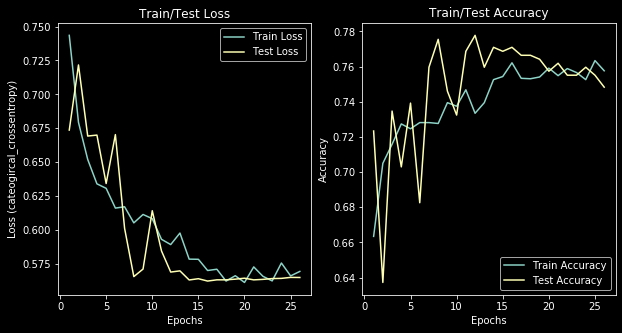

In [23]:
Viz.plot_loss_accuracy(mobilenet_history, 'dark_background', path = 'figures/MV2LossAcc_Edge_Augment.png')  

C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


F1 Scores Test
~~~~~~~~~~~~~~~~~~~~~~
No Weapon: 0.8926174496644296
HandGun: 0.7047619047619047
Rifle: 0.7137546468401488


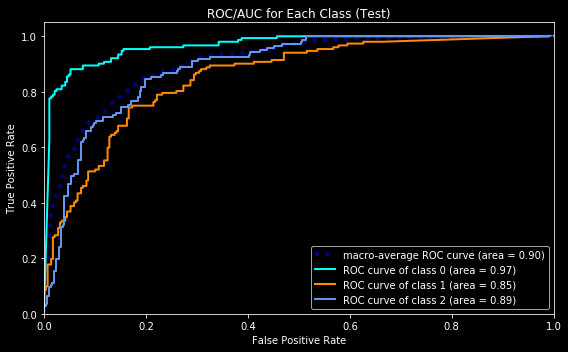

In [24]:
mobilenet = get_mobilenet(dim)
mobilenet.load_weights('ModelWeights/MV2_Edge_Augment.h5') #load the best weights before overfitting

Viz.plot_roc_auc(mobilenet, x_test, y_test, 'dark_background', 'figures/MV2ROC_Edge_Augment.png')

C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


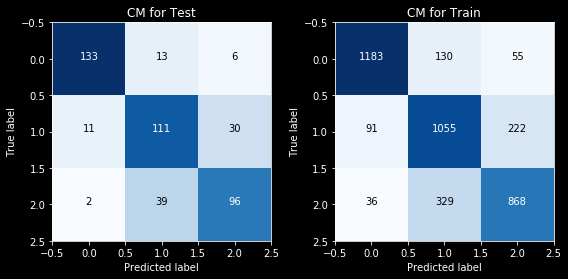

In [25]:
mobilenet = get_mobilenet(dim)
mobilenet.load_weights('ModelWeights/MV2_Edge_Augment.h5') #load the best weights before overfitting

y_test_prob = [np.argmax(i) for i in mobilenet.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

y_train_prob = [np.argmax(i) for i in mobilenet.predict(x_train)]
y_train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(y_train_labels, y_train_prob)

Viz.plot_model_cm(test_cnf, train_cnf, classes = ['No Weapon', 'Handgun', 'Rifle'], theme = 'dark_background', 
                  path = 'figures/MV2CM_Edge_Augment.png')

### V2: Edge & No Augmentation

In [26]:
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .00075)
model_checkpoint = ModelCheckpoint('ModelWeights/MV2_Edge_NoAugment.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 5, mode = 'min')
epochs = 2000
batch_size = 16
    
dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 3)
mobilenet = get_mobilenet(dim =dim)

    
mobilenet_history = mobilenet.fit(x_train, y_train, batch_size = batch_size,
            epochs = epochs, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)

C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Train on 3969 samples, validate on 441 samples
Epoch 1/2000


INFO:plaidml:Analyzing Ops: 1932 of 2044 operations complete


3968/3969 [============================>.] - ETA: 0s - loss: 0.7174 - acc: 0.6830

INFO:plaidml:Analyzing Ops: 1568 of 2039 operations complete


3969/3969 [==============================] - 76s 19ms/step - loss: 0.7174 - acc: 0.6830 - val_loss: 0.6774 - val_acc: 0.7324

Epoch 00001: val_loss improved from inf to 0.67737, saving model to ModelWeights/MV2_Edge_NoAugment.h5
Epoch 2/2000
3969/3969 [==============================] - 25s 6ms/step - loss: 0.6213 - acc: 0.7380 - val_loss: 0.8357 - val_acc: 0.5850

Epoch 00002: val_loss did not improve from 0.67737
Epoch 3/2000
3969/3969 [==============================] - 25s 6ms/step - loss: 0.5876 - acc: 0.7397 - val_loss: 0.7032 - val_acc: 0.6463

Epoch 00003: val_loss did not improve from 0.67737
Epoch 4/2000
3969/3969 [==============================] - 25s 6ms/step - loss: 0.5692 - acc: 0.7639 - val_loss: 0.6596 - val_acc: 0.6893

Epoch 00004: val_loss improved from 0.67737 to 0.65956, saving model to ModelWeights/MV2_Edge_NoAugment.h5
Epoch 5/2000
3969/3969 [==============================] - 25s 6ms/step - loss: 0.5498 - acc: 0.7644 - val_loss: 0.7386 - val_acc: 0.6667

Epoch 0000

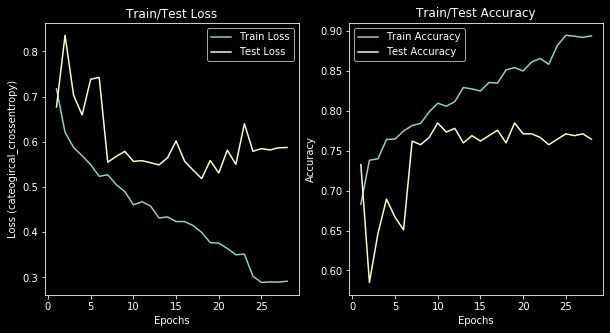

In [27]:
Viz.plot_loss_accuracy(mobilenet_history, 'dark_background', path = 'figures/MV2LossAcc_Edge_NoAugment.png')  

C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


F1 Scores Test
~~~~~~~~~~~~~~~~~~~~~~
No Weapon: 0.896774193548387
HandGun: 0.691588785046729
Rifle: 0.6772908366533865


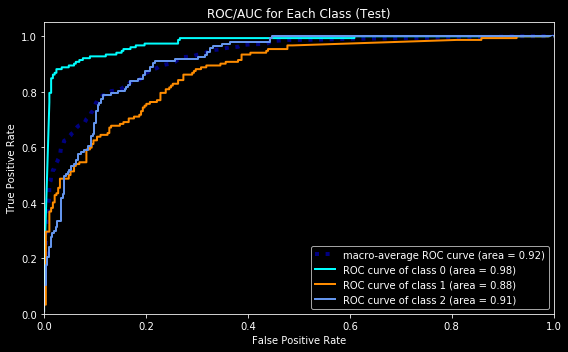

In [28]:
mobilenet = get_mobilenet(dim)
mobilenet.load_weights('ModelWeights/MV2_Edge_NoAugment.h5') #load the best weights before overfitting

Viz.plot_roc_auc(mobilenet, x_test, y_test, 'dark_background', 'figures/MV2ROC_Edge_NoAugment.png')

C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


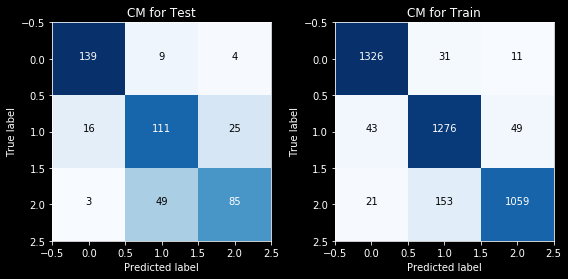

In [29]:
mobilenet = get_mobilenet(dim)
mobilenet.load_weights('ModelWeights/MV2_Edge_NoAugment.h5') #load the best weights before overfitting

y_test_prob = [np.argmax(i) for i in mobilenet.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

y_train_prob = [np.argmax(i) for i in mobilenet.predict(x_train)]
y_train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(y_train_labels, y_train_prob)

Viz.plot_model_cm(test_cnf, train_cnf, classes = ['No Weapon', 'Handgun', 'Rifle'], theme = 'dark_background', 
                  path = 'figures/MV2CM_Edge_NoAugment.png')

### V2: No Edge & Augment

In [3]:
x_train, x_test, y_train, y_test = func.get_tts('mobilenet', version =2, edge = False, balance = True)

# cv2.imshow('test', x_train[25])
# cv2.waitKey(0)
# cv2.destroyAllWindows()

Train Value Counts
1    1368
0    1368
2    1233
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Test Value Counts
1    152
0    152
2    137
dtype: int64
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
X Train Shape
(3969, 224, 224, 3)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
X Test Shape
(441, 224, 224, 3)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [31]:
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .00075)
model_checkpoint = ModelCheckpoint('ModelWeights/MV2_NoEdge_Augment.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 5, mode = 'min')
epochs = 2000
batch_size = 16
    
dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 3)
mobilenet = get_mobilenet(dim =dim)

    
augmentation =ImageDataGenerator(rotation_range = 20, width_shift_range = .2, height_shift_range = .2, 
                                                       horizontal_flip = True, shear_range = .15, 
                                 fill_mode = 'nearest', zoom_range = .15)
augmentation.fit(x_train)
mobilenet_history = mobilenet.fit_generator(augmentation.flow(x_train, y_train, batch_size = batch_size),
            epochs = epochs, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)

C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/2000
249/249 [==============================] - 101s 406ms/step - loss: 0.5968 - acc: 0.7407 - val_loss: 0.8531 - val_acc: 0.6780

Epoch 00001: val_loss improved from inf to 0.85309, saving model to ModelWeights/MV2_NoEdge_Augment.h5
Epoch 2/2000
249/249 [==============================] - 41s 163ms/step - loss: 0.5389 - acc: 0.7761 - val_loss: 1.1644 - val_acc: 0.6508

Epoch 00002: val_loss did not improve from 0.85309
Epoch 3/2000
249/249 [==============================] - 40s 160ms/step - loss: 0.4925 - acc: 0.7919 - val_loss: 0.7432 - val_acc: 0.6825

Epoch 00003: val_loss improved from 0.85309 to 0.74320, saving model to ModelWeights/MV2_NoEdge_Augment.h5
Epoch 4/2000
249/249 [==============================] - 40s 159ms/step - loss: 0.4769 - acc: 0.8037 - val_loss: 0.6261 - val_acc: 0.7551

Epoch 00004: val_loss improved from 0.74320 to 0.62608, saving model to ModelWeights/MV2_NoEdge_Augment.h5
Epoch 5/2000
249/249 [==============================] - 42s 168ms/step - loss: 

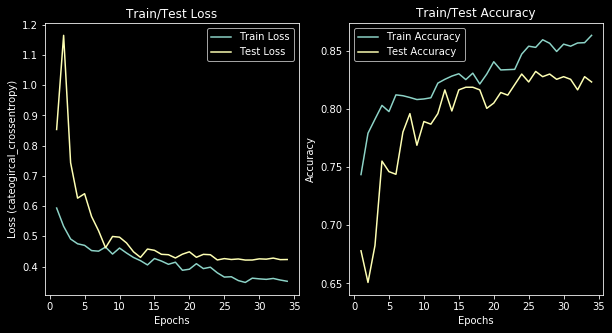

In [32]:
Viz.plot_loss_accuracy(mobilenet_history, 'dark_background', path = 'figures/MV2LossAcc_NoEdge_Augment.png')  

C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


F1 Scores Test
~~~~~~~~~~~~~~~~~~~~~~
No Weapon: 0.9250814332247558
HandGun: 0.7748344370860928
Rifle: 0.783882783882784


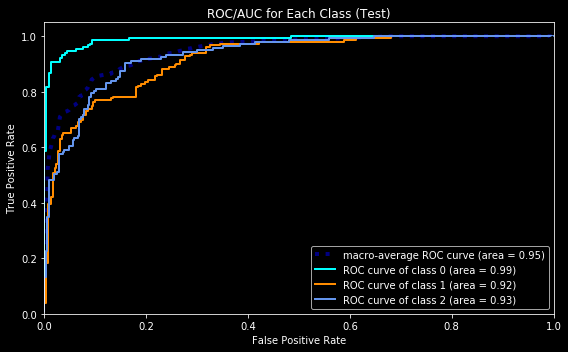

In [33]:
mobilenet = get_mobilenet(dim)
mobilenet.load_weights('ModelWeights/MV2_NoEdge_Augment.h5') #load the best weights before overfitting

Viz.plot_roc_auc(mobilenet, x_test, y_test, 'dark_background', 'figures/MV2ROC_NoEdge_Augment.png')

C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


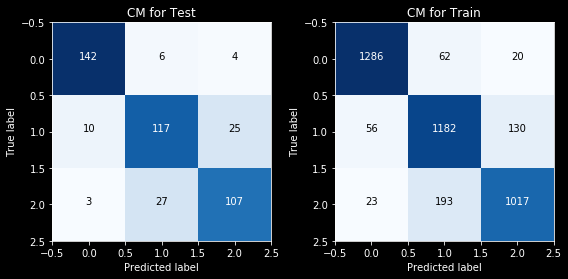

In [34]:
mobilenet = get_mobilenet(dim)
mobilenet.load_weights('ModelWeights/MV2_NoEdge_Augment.h5') #load the best weights before overfitting

y_test_prob = [np.argmax(i) for i in mobilenet.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

y_train_prob = [np.argmax(i) for i in mobilenet.predict(x_train)]
y_train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(y_train_labels, y_train_prob)

Viz.plot_model_cm(test_cnf, train_cnf, classes = ['No Weapon', 'Handgun', 'Rifle'], theme = 'dark_background', 
                  path = 'figures/MV2CM_NoEdge_Augment.png')

### V2: No Edge & No Augment

In [4]:
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .00075)
model_checkpoint = ModelCheckpoint('ModelWeights/MV2_NoEdge_NoAugment.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 5, mode = 'min')
epochs = 2000
batch_size = 16
    
dim = (var.mobilenet_dimension[0], var.mobilenet_dimension[1], 3)
mobilenet = get_mobilenet(dim =dim)

    
mobilenet_history = mobilenet.fit(x_train, y_train, batch_size = batch_size,
            epochs = epochs, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"
C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Train on 3969 samples, validate on 441 samples
Epoch 1/2000
3969/3969 [==============================] - 74s 19ms/step - loss: 0.5804 - acc: 0.7543 - val_loss: 0.9907 - val_acc: 0.6621

Epoch 00001: val_loss improved from inf to 0.99070, saving model to ModelWeights/MV2_NoEdge_NoAugment.h5
Epoch 2/2000
3969/3969 [==============================] - 26s 7ms/step - loss: 0.4744 - acc: 0.8025 - val_loss: 0.8405 - val_acc: 0.6961

Epoch 00002: val_loss improved from 0.99070 to 0.84054, saving model to ModelWeights/MV2_NoEdge_NoAugment.h5
Epoch 3/2000
3969/3969 [==============================] - 26s 7ms/step - loss: 0.4480 - acc: 0.8176 - val_loss: 0.6925 - val_acc: 0.7574

Epoch 00003: val_loss improved from 0.84054 to 0.69251, saving model to ModelWeights/MV2_NoEdge_NoAugment.h5
Epoch 4/2000
3969/3969 [==============================] - 26s 7ms/step - loss: 0.4210 - acc: 0.8279 - val_loss: 0.5480 - val_acc: 0.7778

Epoch 00004: val_loss improved from 0.69251 to 0.54802, saving model to Model

3969/3969 [==============================] - 26s 6ms/step - loss: 0.1661 - acc: 0.9423 - val_loss: 0.3493 - val_acc: 0.8866

Epoch 00039: val_loss did not improve from 0.34649
Epoch 40/2000
3969/3969 [==============================] - 26s 6ms/step - loss: 0.1528 - acc: 0.9451 - val_loss: 0.3526 - val_acc: 0.8844

Epoch 00040: val_loss did not improve from 0.34649
Epoch 41/2000
3969/3969 [==============================] - 26s 6ms/step - loss: 0.1666 - acc: 0.9383 - val_loss: 0.3599 - val_acc: 0.8798

Epoch 00041: val_loss did not improve from 0.34649
Epoch 42/2000
3969/3969 [==============================] - 26s 6ms/step - loss: 0.1536 - acc: 0.9483 - val_loss: 0.3465 - val_acc: 0.8866

Epoch 00042: val_loss did not improve from 0.34649
Epoch 43/2000
3969/3969 [==============================] - 26s 6ms/step - loss: 0.1641 - acc: 0.9408 - val_loss: 0.3490 - val_acc: 0.8866

Epoch 00043: val_loss did not improve from 0.34649
Epoch 44/2000
3969/3969 [==============================] - 26s 6

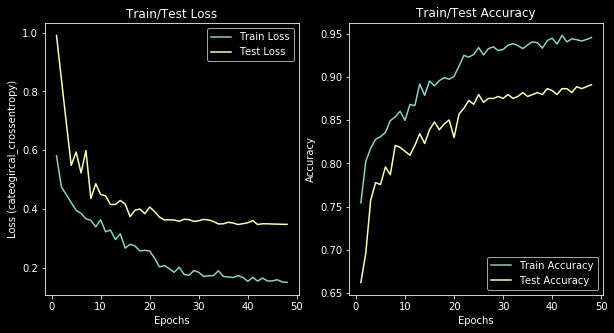

In [5]:
Viz.plot_loss_accuracy(mobilenet_history, 'dark_background', path = 'figures/MV2LossAcc_NoEdge_NoAugment.png')  

C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


F1 Scores Test
~~~~~~~~~~~~~~~~~~~~~~
No Weapon: 0.9385113268608415
HandGun: 0.8421052631578947
Rifle: 0.8550185873605949


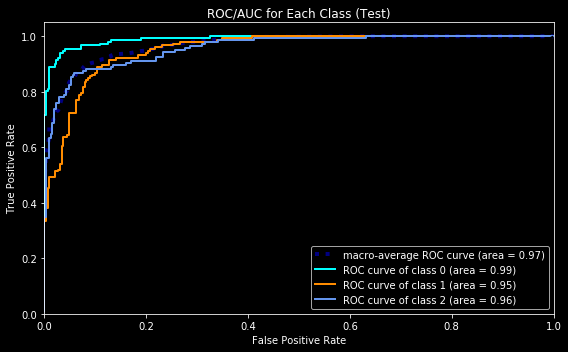

In [6]:
mobilenet = get_mobilenet(dim)
mobilenet.load_weights('ModelWeights/MV2_NoEdge_NoAugment.h5') #load the best weights before overfitting

Viz.plot_roc_auc(mobilenet, x_test, y_test, 'dark_background', 'figures/MV2ROC_NoEdge_NoAugment.png')

C:\Users\Heeeb\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


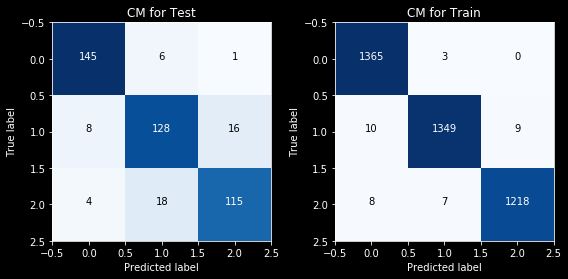

In [7]:
mobilenet = get_mobilenet(dim)
mobilenet.load_weights('ModelWeights/MV2_NoEdge_NoAugment.h5') #load the best weights before overfitting

y_test_prob = [np.argmax(i) for i in mobilenet.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

y_train_prob = [np.argmax(i) for i in mobilenet.predict(x_train)]
y_train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(y_train_labels, y_train_prob)

Viz.plot_model_cm(test_cnf, train_cnf, classes = ['No Weapon', 'Handgun', 'Rifle'], theme = 'dark_background', 
                  path = 'figures/MV2CM_NoEdge_NoAugment.png')

In [ ]:
// %%javascript
// IPython.notebook.save_notebook()

In [ ]:
# import os
# os.system(r'%windir%\system32\rundll32.exe powrprof.dll,SetSuspendState Hibernate')